In [129]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


In [130]:

from utils.utils import *
from utils.constants import *
from utils.args import *
from run_experiment import * 

from torch.utils.tensorboard import SummaryWriter

# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

import numba 
import matplotlib


In [138]:
# Generating Empty Aggregator to be loaded 

setting = 'FedAvg'

if setting == 'FedEM':
    nL = 3
else:
    nL = 1

# Manually set argument parameters
args_ = Args()
args_.experiment = "cifar100"
args_.method = setting
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= nL
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.01
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/cifar/dummy/'
args_.validation = False

# Generate the dummy values here
aggregator, clients = dummy_aggregator(args_, num_user=20)

==> Clients initialization..
===> Building data iterators..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 174.43it/s]


===> Initializing clients..


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.03it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 4.611 | Train Acc: 1.100% |Test Loss: 4.608 | Test Acc: 1.250% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


In [139]:
num_records = []
for c in clients:
    num_records+=[c.train_iterator.dataset.targets.shape[0]]

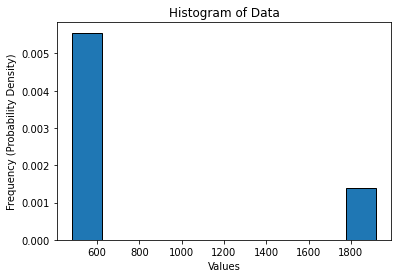

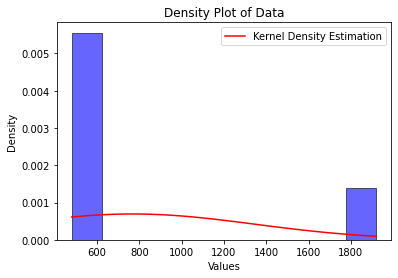

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace this with your actual list of values)
data = num_records

# Plotting histogram
plt.hist(data, bins=10, density=True, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency (Probability Density)')
plt.title('Histogram of Data')
plt.show()

# Alternatively, plot density plot (kernel density estimation)
plt.figure()
plt.hist(data, bins=10, density=True, alpha=0.6, color='blue', edgecolor='black')
plt.plot(np.linspace(min(data), max(data), 100), 
         np.exp(-0.5*((np.linspace(min(data), max(data), 100) - np.mean(data)) / np.std(data))**2) / (np.std(data) * np.sqrt(2 * np.pi)),
         label='Kernel Density Estimation', color='red')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Density Plot of Data')
plt.legend()
plt.show()


In [141]:
np.sum(data)

15360

In [142]:
data

[480,
 1920,
 480,
 1920,
 480,
 480,
 480,
 480,
 480,
 480,
 480,
 1920,
 480,
 480,
 480,
 480,
 480,
 480,
 480,
 1920]

In [117]:
reward_threshold = 0.00

participant_file = "/home/ubuntu/FedEM/distmec_participant_pkls/23_07_27_participant_array_40c_hard0.pkl"
# participant_file = "/home/ubuntu/FedEM/distmec_participant_pkls/23_07_27_participant_array_40c_4.pkl"


with open(participant_file, "rb") as tf:
    loaded_dict = pickle.load(tf)

participant_list = []
participant_list += [loaded_dict['Users_w_sa']]
participant_list += [loaded_dict['Users_rsv_sa']]
participant_list += [loaded_dict['GoT_Users_sa']]

itts = [0,1,2]
record_uw = []
record_rsv = []
record_got = []
total_rec = [record_uw, record_rsv, record_got]

for t in range(40,500):
    for itt in itts:
        participant_sub = participant_list[itt][:,t]
        participant_id = np.where(participant_sub > reward_threshold)[0]
        total_rec[itt] += [len(participant_id)]

In [118]:
np.mean(record_uw)

6.593478260869565

In [119]:
np.mean(record_rsv)

19.504347826086956

In [120]:
np.mean(record_got)

6.515217391304348

In [102]:
itt = 1
for t in range(40,500):
    participant_sub = participant_list[itt][:,t]
    participant_id = np.where(participant_sub > reward_threshold)[0]
    total_rec[itt] += [len(participant_id)]

In [103]:
participant_sub

array([0.00000000e+00, 2.69090909e-06, 0.00000000e+00, 9.52736800e-01,
       6.86370500e-01, 0.00000000e+00, 4.08185900e-01, 0.00000000e+00,
       0.00000000e+00, 3.72731000e-01, 0.00000000e+00, 0.00000000e+00,
       5.00914100e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.48191300e-01, 0.00000000e+00, 6.03642400e-01, 3.48185300e-01,
       0.00000000e+00, 5.45460000e-01, 8.05462600e-01, 0.00000000e+00,
       0.00000000e+00, 4.25454545e-06, 4.40000000e-06, 4.99095900e-01,
       5.79096700e-01, 1.00001000e+00, 3.09090909e-06, 4.25458800e-01,
       6.32733600e-01, 6.23642600e-01, 0.00000000e+00, 3.05457600e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.78191600e-01])